# Topic Modelling

Note: Interactive features like plotly and gensim won't work on GitHub.com. Use [nbviewer](https://nbviewer.org/github/DATA-606-2023-FALL-MONDAY/Kandlagunta_Dheeraj/blob/main/src/Yelp%20Explorer%20-%204.%20Topic%20Modeling.ipynb) to view.

Topic modeling refers to a statistical approach used to identify the underlying "topics" present in a group of documents. An example of this technique is Latent Dirichlet Allocation (LDA), which categorizes the text within a document into specific topics. This method constructs a model for each document based on its topics, and a model for each topic based on its words, utilizing Dirichlet distributions for modeling.

In [1]:
# Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

In [2]:
# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

In [3]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors

In [4]:
data_path = "../../../yelp_dataset/"

In [5]:
# Reading in Reviews CSV File

reviews_sentiment = pd.read_csv(data_path + "reviews_sentiment.csv")
reviews_sentiment.drop(['Unnamed: 0'], axis=1, inplace = True)
print(reviews_sentiment.shape)
reviews_sentiment.sample(3)

(345849, 20)


,review_id,user_id,business_id,stars,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
269836,k5Cjfn-0GozJa0wkDuGeGg,Zu_03z1M7NB1AxdDDt2www,A37C-01zpQty9FmxvZrxEg,5.0,This food is not only fantastic but also extre...,2020-12-20 02:32:08,2020,12,02:32:08,38,248,5.552632,15,food fantastic extremely authentic strawberry ...,0.325000,0.743750,0.046,0.849,0.104,0.5355
237938,UEqFwyTj0rKjFpcLdoEn6A,6_4RSu_bDVO983uwuud2nQ,xb5NsCqvQw2uE5HoQyDr0g,4.0,The famous pound cake was DELICIOUS! Perfectly...,2017-07-02 19:32:22,2017,7,19:32:22,132,723,4.436090,52,famous pound cake delicious perfectly soft den...,0.238804,0.457483,0.068,0.681,0.251,0.9682
72884,v2CAps_Amq-hTsWn1sgbpg,VBde9_Ibl9Q0H8fCjDMTZQ,Ep_jh1Pt4Ggyla21f-BQcQ,5.0,Yum \nWe love this place - unfortunately we ar...,2021-10-31 21:04:14,2021,10,21:04:14,46,227,3.708333,21,yum love place unfortunately local visit weve ...,0.333333,0.496296,0.075,0.716,0.210,0.8360


In [6]:
# Filtering for reviews that have 0.0 scores across 3 metrics: polarity, subjectivity, compound

dropped_reviews = reviews_sentiment[(reviews_sentiment.polarity ==0.0) & (reviews_sentiment.compound==0.0) & (reviews_sentiment.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(588, 20)


,review_id,user_id,business_id,stars,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
307594,nzM-zmqXLNTY7tW0m_8trQ,SHpy06xh0ZzAHJiSHOxKqA,iksVwRfpWymIUUFqw0tXpw,5.0,The hotpot was banging. 10/10 would eat again....,2018-12-17 04:49:57,2018,12,04:49:57,19,100,4.315789,6,hotpot banging 1010 eat beef sooo tender wagyu...,0.0,0.0,0.0,1.0,0.0,0.0
317411,NXdO0bL68Iy8BfcZmds2TQ,2lAAu6mqJrg23bYdXubhrw,ytynqOUb3hjKeJfRj5Tshw,5.0,Haven't been here in awhile but I know it's a ...,2021-07-05 23:45:53,2021,7,23:45:53,19,104,4.526316,9,havent awhile philadelphia staple must youre v...,0.0,0.0,0.0,1.0,0.0,0.0
99885,9rTcnpBfJ8hAs7yPeSR5XA,h9SOZqCqvMz-HfymIS08qw,Jn4tRtjIuz6MBCykQySpeg,5.0,Just go!! \n\nIf you don't get a cheesesteak f...,2019-06-16 19:55:10,2019,6,19:55:10,15,86,4.666667,9,dont cheesesteak disservice,0.0,0.0,0.0,1.0,0.0,0.0
157794,sqCS0kzxzbrgfSI7VXrorQ,db-GHRF-57X4T_CM4-Mp5w,DZglT5FP5VNDQJU3PuRIHw,1.0,Saw one hair...let it go. Then came another ha...,2018-01-22 00:41:49,2018,1,00:41:49,21,121,4.545455,7,saw one hairlet came another hair ordered cavi...,0.0,0.0,0.0,1.0,0.0,0.0
155942,8-04v6irH5kgG0TpqESitQ,MXOBUdoJg1q4jsIam_lqYg,TE2IEDNV0RcI6s1wTOP4fg,5.0,我想可能这是对此店铺的第一封中文点评吧。坐落在意大利市场拐角处的这家墨西哥玉米饼，价格低廉，...,2016-05-29 07:46:52,2016,5,07:46:52,1,96,96.000000,0,我想可能这是对此店铺的第一封中文点评吧坐落在意大利市场拐角处的这家墨西哥玉米饼价格低廉味道十...,0.0,0.0,0.0,1.0,0.0,0.0


The table presented above indicates that the reviews are in languages other than English. Consequently, sentiment analysis tools are unable to accurately assess these reviews. Therefore, for the objectives of this project, we will exclude these 866 rows of non-English reviews.

In [7]:
# Dropping these filtered rows

reviews_sentiment = reviews_sentiment.drop(index = dropped_reviews.index)
print(reviews_sentiment.shape)
reviews_sentiment.sample(3)

(345261, 20)


,review_id,user_id,business_id,stars,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
206816,TZDEjMn3vAIqJ9IZ1TVCAQ,iz60gEtUWsbgb1oGQRPaRg,7pAgxBMUjrVPH7xh3fn-gw,5.0,"The food was amazing, the place was clean and ...",2021-04-01 17:27:31,2021,4,17:27:31,16,90,4.687500,7,food amazing place clean staff accommodating l...,0.555556,0.800000,0.000,0.529,0.471,0.9110
187958,3BOjnPmKmHKexEgkkCREig,y0AaiNsbxTfX8dzqrUTbAA,OChSrnaj5tQ1-wm7zoVT4w,1.0,Me and my boyfriend arrived at 7:55 and the ho...,2019-01-18 03:24:20,2019,1,03:24:20,253,1310,4.181818,121,boyfriend arrived 755 hostess told u longer ho...,0.109091,0.142424,0.017,0.939,0.044,0.7269
256685,DouKjs4GpiubiijF58Jg3A,ptmF2de6-hIOXjyiu77-jA,lWedWkinrM5j13pyimbpbA,5.0,This is our favorite brunch spot in the city. ...,2017-05-24 06:06:18,2017,5,06:06:18,47,252,4.382979,19,favorite brunch spot city yet disappointed any...,0.119524,0.635714,0.059,0.840,0.101,0.2960


In [8]:
# Pre-compile regular expressions for efficiency
newline_pattern = re.compile('\s+')
single_quote_pattern = re.compile("\'")

def convert_sentences_to_words(list_of_sentences):
    processed_sentences = []
    for sentence in list_of_sentences:
        # Applying pre-compiled regex for efficiency
        sentence = newline_pattern.sub(' ', sentence)
        sentence = single_quote_pattern.sub('', sentence)
        processed_sentence = gensim.utils.simple_preprocess(str(sentence), deacc=True)
        processed_sentences.append(processed_sentence)
    return processed_sentences

# Creating a list from the text data
data = reviews_sentiment.text.values.tolist()
list_of_data_words = convert_sentences_to_words(data)
print(list_of_data_words[:1])


[['wow', 'yummy', 'different', 'delicious', 'our', 'favorite', 'is', 'the', 'lamb', 'curry', 'and', 'korma', 'with', 'different', 'kinds', 'of', 'naan', 'dont', 'let', 'the', 'outside', 'deter', 'you', 'because', 'we', 'almost', 'changed', 'our', 'minds', 'go', 'in', 'and', 'try', 'something', 'new', 'youll', 'be', 'glad', 'you', 'did']]


In [9]:
# Load Spacy model outside the function for efficiency
nlp_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def refine_text(input_texts, stop_words=stop_words, permitted_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Function for text refinement: stopwords removal and lemmatization"""
    filtered_texts = [[term for term in simple_preprocess(str(document)) if term not in stop_words] for document in input_texts]
    lemmatized_output = []

    for sentence in filtered_texts:
        doc = nlp_model(" ".join(sentence))
        lemmatized_output.append([token.lemma_ for token in doc if token.pos_ in permitted_postags])

    # Further stopwords removal post-lemmatization
    final_output = [[term for term in simple_preprocess(str(doc)) if term not in stop_words] for doc in lemmatized_output]
    return final_output

processed_data = refine_text(list_of_data_words)


In [10]:
# Constructing a Dictionary from Processed Data
word_id_mapping = corpora.Dictionary(processed_data)

# Building the Corpus with Term Document Frequency
document_corpus = [word_id_mapping.doc2bow(text) for text in processed_data]


In [11]:
# Initializing an LDA model
lda_analysis_model = gensim.models.ldamodel.LdaModel(corpus=document_corpus,
                                                     id2word=word_id_mapping,
                                                     num_topics=5,
                                                     random_state=42,
                                                     chunksize=250,
                                                     passes=5,
                                                     alpha='auto',
                                                     iterations=10,
                                                     per_word_topics=False)


In [12]:
# Displaying the Primary Topics from the LDA Model
pprint(lda_analysis_model.print_topics())


[(0,
  '0.041*"food" + 0.036*"place" + 0.034*"great" + 0.017*"service" + '
  '0.015*"love" + 0.014*"really" + 0.013*"definitely" + 0.013*"well" + '
  '0.013*"amazing" + 0.013*"time"'),
 (1,
  '0.106*"pizza" + 0.054*"sandwich" + 0.054*"cheese" + 0.034*"fry" + '
  '0.033*"steak" + 0.019*"chicken" + 0.019*"order" + 0.019*"cheesesteak" + '
  '0.019*"burger" + 0.018*"wing"'),
 (2,
  '0.041*"order" + 0.020*"time" + 0.017*"food" + 0.014*"wait" + 0.014*"give" + '
  '0.012*"ask" + 0.011*"table" + 0.011*"never" + 0.010*"tell" + '
  '0.009*"minute"'),
 (3,
  '0.016*"coffee" + 0.013*"breakfast" + 0.010*"location" + 0.009*"egg" + '
  '0.009*"find" + 0.008*"day" + 0.008*"toast" + 0.007*"old" + 0.006*"look" + '
  '0.006*"brunch"'),
 (4,
  '0.017*"taste" + 0.016*"flavor" + 0.016*"dish" + 0.016*"order" + '
  '0.015*"sauce" + 0.013*"roll" + 0.013*"chicken" + 0.009*"salad" + '
  '0.009*"side" + 0.009*"sweet"')]


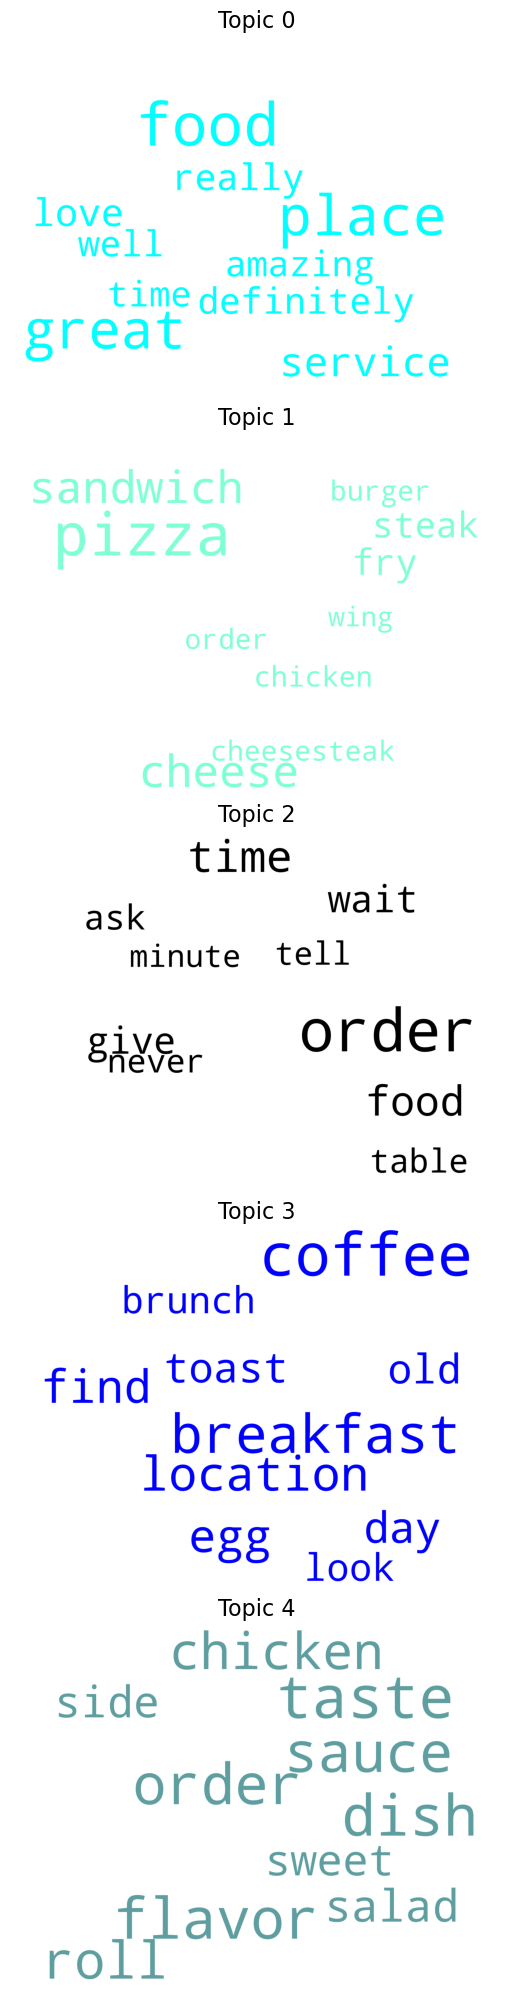

In [13]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Selecting darker colors from a different palette
colors = [color for name, color in mcolors.CSS4_COLORS.items() if mcolors.to_rgb(color)[:3] < (0.5, 0.5, 0.5)]

word_cloud = WordCloud(stopwords=stop_words,
                       background_color='white',  # Set background to white
                       width=2500,
                       height=1800,
                       max_words=10,
                       colormap='tab10',
                       color_func=lambda *args, **kwargs: colors[i % len(colors)],  # Cycle through dark colors
                       prefer_horizontal=1.0)

lda_topics = lda_analysis_model.show_topics(formatted=False)

# Set up plot structure
fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, axis in enumerate(axes.flatten()):
    fig.add_subplot(axis)
    topic_terms = dict(lda_topics[i][1])
    word_cloud.generate_from_frequencies(topic_terms, max_font_size=300)
    plt.gca().imshow(word_cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


Analyzing word distributions in Yelp reviews reveals distinct dining themes. Topic 0, with words like "great" and "love," suggests overall **positive dining experiences**, encompassing satisfaction with food, ambiance, and service. Topic 1, featuring "burger" and "pizza," points to **American cuisine**, indicating reviews of traditional American restaurants. Topic 2's focus on "order" and "wait" reflects concerns about **service and wait times**, highlighting operational aspects of dining. Topic 3, with "coffee" and "breakfast," suggests a focus on **cafes**. Finally, Topic 4, including "roll" and "sauce," implies **Asian cuisine**, with reviews likely centered on Asian restaurants. Each topic captures a unique facet of dining experiences.

In [14]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_analysis_model, document_corpus, dictionary=lda_analysis_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.177304  0.183461       1        1  33.789079
2     -0.183199  0.075258       2        1  25.847047
4      0.149276  0.060318       3        1  21.392240
3     -0.133850 -0.307779       4        1  12.874101
1      0.345077 -0.011258       5        1   6.097532, topic_info=          Term           Freq          Total Category  logprob  loglift
429      pizza   85419.000000   85419.000000  Default  30.0000  30.0000
55       great  152065.000000  152065.000000  Default  29.0000  29.0000
145      order  198862.000000  198862.000000  Default  28.0000  28.0000
41        food  242302.000000  242302.000000  Default  27.0000  27.0000
1833  sandwich   43490.000000   43490.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
35      philly    5768.323579   45903.483915   Topic5  -4.9354   0.7231
728     pepper    4087.076313   11692.160085   Topic5  -5.2799   1.7462
2407   italian    3827.760631   13342.128688   Topic5  -5.3455   1.5486
15         eat    4221.717458   67536.543356   Topic5  -5.2475   0.0249
150      taste    4100.060558   53793.618254   Topic5  -5.2768   0.2231

[310 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
11        1  0.999985     always
174       1  0.999991    amazing
103       1  0.999850   ambiance
587       2  0.999905     arrive
222       2  0.999976        ask
...     ...       ...        ...
441       5  0.999925       wing
30        1  0.999928  wonderful
379       1  0.238992       work
379       2  0.504539       work
379       4  0.256455       work

[441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

In [15]:
def format_topics_sentences(ldamodel=None, corpus=document_corpus, texts=processed_data):
    # Pre-allocate list for storing topic info
    topic_info = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: x[1], reverse=True)
        
        # Get the dominant topic, percentage contribution, and keywords
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        topic_info.append([int(topic_num), topic_keywords])

    # Create a DataFrame
    sent_topics_df = pd.DataFrame(topic_info, columns=['Dominant_Topic', 'Topic_Keywords'])

    # Add the original text data
    sent_topics_df['Text'] = texts

    return sent_topics_df

# Example usage
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_analysis_model, corpus=document_corpus, texts=processed_data)


In [16]:
# Efficiently format and display the DataFrame
df_dominant_topic = df_topic_sents_keywords.reset_index().rename(columns={'index': 'Document_No', 0: 'Dominant_Topic', 1: 'Keywords', 2: 'Text'})
print("DataFrame Shape:", df_dominant_topic.shape)
df_dominant_topic.sample(10)


DataFrame Shape: (345261, 4)


,Document_No,Dominant_Topic,Topic_Keywords,Text
110107,110107,0,"food, place, great, service, love, really, def...","[wait, reservation, spot, order, deeeelicious,..."
121623,121623,0,"food, place, great, service, love, really, def...","[place, south, steak, great, upstairs, quiet, ..."
250558,250558,1,"pizza, sandwich, cheese, fry, steak, chicken, ...","[cheesesteak, wit, onion, worst, cheesesteak, ..."
201308,201308,0,"food, place, great, service, love, really, def...","[food, well, cook, bland, taste, food, well, p..."
259400,259400,0,"food, place, great, service, love, really, def...","[fantastic, pork, beef, superb, rage, spinach,..."
136931,136931,1,"pizza, sandwich, cheese, fry, steak, chicken, ...","[first, visit, plain, jane, basically, sloppy,..."
98027,98027,0,"food, place, great, service, love, really, def...","[ikea, couple, time, year, sometimes, look, th..."
274415,274415,0,"food, place, great, service, love, really, def...","[spot, cute, food, absolutely, incredible, loc..."
120209,120209,0,"food, place, great, service, love, really, def...","[great, staff, awesome, food, great, venue, li..."
172349,172349,4,"taste, flavor, dish, order, sauce, roll, chick...","[hear, pizza, well, philly, crust, chewy, sauc..."


In [17]:
# Directly append new columns to the reviews dataset
final_reviews = reviews_sentiment.copy()
final_reviews['Dominant_Topic'] = df_dominant_topic['Dominant_Topic']
final_reviews['Keywords'] = df_dominant_topic['Topic_Keywords']
final_reviews['Text_Chunks'] = df_dominant_topic['Text']

# Reindex if necessary - ensure combined_reviews.index is appropriate
final_reviews = final_reviews.reindex(reviews_sentiment.index) if 'reviews_sentiment' in locals() else final_reviews

# Display the first 10 rows
final_reviews.head(10)


,review_id,user_id,business_id,stars,text,date,year,month,time,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,1,00:01:03,48,243,4.900000,12,wow yummy different delicious favorite lamb cu...,0.315152,0.733838,0.000,0.660,0.340,0.9588,0.0,"food, place, great, service, love, really, def...","[different, favorite, different, kind, let, ou..."
1,T_kAb2NeylB-JdNDKphryw,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5.0,We've eaten here 3 times and it seems that eac...,2017-01-02 14:25:26,2017,1,14:25:26,66,341,4.246154,26,weve eaten 3 time seems time get better shrimp...,0.265476,0.591667,0.022,0.772,0.206,0.9339,0.0,"food, place, great, service, love, really, def...","[eat, time, time, well, shrimp, malabar, last,..."
2,NENaCqb6TNj5CyY1LOdI6Q,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5.0,Came to Philly for a family event but stayed a...,2015-07-28 17:15:20,2015,7,17:15:20,28,149,4.357143,13,came philly family event stayed little dinner ...,0.178125,0.862500,0.000,0.730,0.270,0.8918,0.0,"food, place, great, service, love, really, def...","[philly, family, event, stay, little, dinner, ..."
3,l-bH0C-PSXmVs-vQqMfJ1Q,toFm0jWZJKqsOmHE7kMbRA,kxX2SOes4o-D3ZQBkiMRfA,5.0,A very neat little hole in the wall. Very clea...,2015-06-21 01:11:14,2015,6,01:11:14,23,131,4.739130,8,neat little hole wall clean extremely food rea...,0.050833,0.560000,0.000,0.604,0.396,0.9095,0.0,"food, place, great, service, love, really, def...","[neat, little, hole, wall, clean, extremely, f..."
4,qr7acpL3ZzP7cAmXaax93w,cMvau1VAjuKo_ah0ZBck1g,kxX2SOes4o-D3ZQBkiMRfA,4.0,This place was a great find. I'd say its a 4.5...,2015-12-06 01:36:28,2015,12,01:36:28,91,465,4.120879,32,place great find id 45 interior decor food rea...,0.260000,0.530000,0.080,0.655,0.265,0.9731,0.0,"food, place, great, service, love, really, def...","[place, great, find, interior, decor, food, re..."
5,T4eUUk_WL-m_wbfjczt8WQ,MpIZMLdDjZRu5BzGyEjEOw,kxX2SOes4o-D3ZQBkiMRfA,5.0,"I love the food, love the owner the lady who w...",2016-07-15 01:02:25,2016,7,01:02:25,103,539,4.242718,44,love food love owner lady wait lovely warm chi...,0.426667,0.666667,0.000,0.680,0.320,0.9894,0.0,"food, place, great, service, love, really, def...","[love, food, love, owner, lady, wait, lovely, ..."
6,VmM83BrA_db6jd1IwhNALw,JXB91quCyabpRX0fwP-RDA,kxX2SOes4o-D3ZQBkiMRfA,5.0,"I love the nice friendly service,great Indian ...",2015-09-10 17:33:00,2015,9,17:33:00,25,169,5.800000,7,love friendly servicegreat indian cuisine chic...,0.318750,0.762500,0.000,0.602,0.398,0.9313,0.0,"food, place, great, service, love, really, def...","[love, friendly, service, great, indian, cuisi..."
7,Qrp16dGOB7ZLS0f3tizVgQ,LOVArG-JZc7Guw_fy2EgHQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,A must for all those who want a really tasty m...,2015-02-03 00:47:32,2015,2,00:47:32,100,636,5.000000,41,must really tasty meal portion huge spice leve...,0.152597,0.751623,0.032,0.759,0.209,0.9645,0.0,"food, place, great, service, love, really, def...","[really, tasty, meal, portion, huge, spice, le..."
8,Ol2Y4ficEqARYj-FfBG0fg,UzzWl_rQkjAi1iRzd-e-ZA,kxX2SOes4o-D3ZQBkiMRfA,5.0,Came here with my husband one night after he c...,2016-02-14 19:09:57,2016,2,19:09:57,72,390,4.430556,34,came husband one night stop raving food kabob ...,0.371429,0.721429,0.000,0.760,0.240,0.9614,0.0,"food, place, great, service, love, really, def...","[husband, night, stop, rave, food, kabob, chic..."
9,Q903_7csIN9PMwq_9ZQXSQ,F7j1AubXAJL7BdLoQS4XQQ,kxX2SOes4o-D3ZQBkiMRfA,1.0,Dissapointing. Went towards the end of the day...,2017-10-12 10:39:39,2017,10,10:39:39,92,467,4.065217,37,dissapointing went towards end day ordered chi...,-0.216270,0.544048,0.067,0.873,0.059,0.0572,4.0,"taste, flavor, dish, order, sauce, roll, chick...","[dissapointing, end, day, order

In [18]:
# Save final_reviews into csv file

final_reviews.to_csv(data_path + "final_reviews.csv")